### Online Retail Data Set

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

### Attribute Information:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides. 

Accurately predicted monthly revenue is needed to improve manager and executive decision making

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)


from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.ensemble import ExtraTreesRegressor

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

np.random.seed(0)

#from pycaret.classification import *
#from pycaret.clustering import *
from pycaret.regression import *

pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)

### Data Preprocessing

In [2]:
df = pd.read_csv("retailnew.csv")

In [3]:
df

,DaySum,MonthSum,QuantitySum,TotalPriceSum,CustomerCount,DayAvg,MonthAvg,QuantityAvg
0,1059,361,1037,759.89,73,14.506849,4.945205,14.205479
1,402,175,495,119.09,24,16.750000,7.291667,20.625000
2,462,176,193,40.53,30,15.400000,5.866667,6.433333
3,61,17,-13,3.25,4,15.250000,4.250000,-3.250000
4,4,8,-38,0.00,1,4.000000,8.000000,-38.000000
...,...,...,...,...,...,...,...,...
4065,165,48,20,167.05,10,16.500000,4.800000,2.000000
4066,144,42,37,175.53,8,18.000000,5.250000,4.625000
4067,51,23,3,100.70,3,17.000000,7.666667,1.000000
4068,82,30,4,167.56,4,20.500000,7.500000,1.000000


### MonthSum is target variable

In [4]:
df.columns

Index(['DaySum', 'MonthSum', 'QuantitySum', 'TotalPriceSum', 'CustomerCount', 'DayAvg', 'MonthAvg', 'QuantityAvg'], dtype='object')

In [5]:
df = df[['DaySum','QuantitySum', 'TotalPriceSum', 'CustomerCount', 'DayAvg', 'MonthAvg', 'QuantityAvg','MonthSum']]

In [6]:
df

,DaySum,QuantitySum,TotalPriceSum,CustomerCount,DayAvg,MonthAvg,QuantityAvg,MonthSum
0,1059,1037,759.89,73,14.506849,4.945205,14.205479,361
1,402,495,119.09,24,16.750000,7.291667,20.625000,175
2,462,193,40.53,30,15.400000,5.866667,6.433333,176
3,61,-13,3.25,4,15.250000,4.250000,-3.250000,17
4,4,-38,0.00,1,4.000000,8.000000,-38.000000,8
...,...,...,...,...,...,...,...,...
4065,165,20,167.05,10,16.500000,4.800000,2.000000,48
4066,144,37,175.53,8,18.000000,5.250000,4.625000,42
4067,51,3,100.70,3,17.000000,7.666667,1.000000,23
4068,82,4,167.56,4,20.500000,7.500000,1.000000,30


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DaySum         4070 non-null   int64  
 1   QuantitySum    4070 non-null   int64  
 2   TotalPriceSum  4070 non-null   float64
 3   CustomerCount  4070 non-null   int64  
 4   DayAvg         4070 non-null   float64
 5   MonthAvg       4070 non-null   float64
 6   QuantityAvg    4070 non-null   float64
 7   MonthSum       4070 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 254.5 KB


In [8]:
df.describe()

,DaySum,QuantitySum,TotalPriceSum,CustomerCount,DayAvg,MonthAvg,QuantityAvg,MonthSum
count,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000
mean,2084.604914,1271.855037,2395.024062,133.147174,15.542543,6.775908,1.054012,921.355528
std,3136.878707,3052.458716,7931.603222,199.903331,3.326412,1.551180,123.210129,1381.391142
min,1.000000,-14418.000000,-221520.500000,1.000000,1.000000,1.000000,-5368.000000,1.000000
25%,214.000000,32.000000,95.197500,14.000000,14.389881,6.092182,2.000000,92.250000
50%,951.000000,300.500000,612.650000,62.000000,15.500000,6.800000,4.637055,405.000000
75%,2626.500000,1279.500000,2087.657500,167.000000,16.576232,7.600000,8.976561,1172.750000
max,34907.000000,56450.000000,206245.480000,2313.000000,31.000000,12.000000,957.750000,15288.000000


In [9]:
df.shape

(4070, 8)

### Train Test Split

In [10]:
X = df.iloc[:,0:7]
y = df.iloc[:,7]

In [11]:
X.values, y.values

(array([[1.05900000e+03, 1.03700000e+03, 7.59890000e+02, ...,
         1.45068493e+01, 4.94520548e+00, 1.42054795e+01],
        [4.02000000e+02, 4.95000000e+02, 1.19090000e+02, ...,
         1.67500000e+01, 7.29166667e+00, 2.06250000e+01],
        [4.62000000e+02, 1.93000000e+02, 4.05300000e+01, ...,
         1.54000000e+01, 5.86666667e+00, 6.43333333e+00],
        ...,
        [5.10000000e+01, 3.00000000e+00, 1.00700000e+02, ...,
         1.70000000e+01, 7.66666667e+00, 1.00000000e+00],
        [8.20000000e+01, 4.00000000e+00, 1.67560000e+02, ...,
         2.05000000e+01, 7.50000000e+00, 1.00000000e+00],
        [2.10000000e+01, 1.00000000e+00, 2.55000000e+00, ...,
         2.10000000e+01, 1.20000000e+01, 1.00000000e+00]]),
 array([361, 175, 176, ...,  23,  30,  12], dtype=int64))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3256, 7), (814, 7), (3256,), (814,))

### Feature Scaling

In [14]:
X_train

,DaySum,QuantitySum,TotalPriceSum,CustomerCount,DayAvg,MonthAvg,QuantityAvg
1651,3842,8496,7320.51,237,16.210970,7.164557,35.848101
3803,445,102,77.79,28,15.892857,8.107143,3.642857
2057,3397,1777,4400.82,211,16.099526,7.208531,8.421801
263,28,-1,0.00,1,28.000000,1.000000,-1.000000
1763,1904,1119,1849.23,142,13.408451,4.295775,7.880282
...,...,...,...,...,...,...,...
835,1568,1275,1014.14,91,17.230769,7.373626,14.010989
3264,221,511,154.39,18,12.277778,7.111111,28.388889
1653,3293,928,2402.64,211,15.606635,6.374408,4.398104
2607,253,48,120.00,19,13.315789,5.000000,2.526316


In [15]:
scaler = StandardScaler()

In [16]:
X_train_scaled = scaler.fit_transform(X_train)

In [17]:
X_test_scaled = scaler.transform(X_test)

In [18]:
X_train_scaled

array([[ 5.53066525e-01,  2.32274954e+00,  5.87761776e-01, ...,
         1.94874483e-01,  2.42770327e-01,  3.44821031e-01],
       [-5.27633995e-01, -3.87276914e-01, -2.81811153e-01, ...,
         9.74236864e-02,  8.52791675e-01,  1.66371006e-02],
       [ 4.11496984e-01,  1.53501537e-01,  2.37218971e-01, ...,
         1.60734620e-01,  2.71229254e-01,  6.53363918e-02],
       ...,
       [ 3.78411069e-01, -1.20600496e-01, -2.68582097e-03, ...,
         9.74245150e-03, -2.68597381e-01,  2.43333617e-02],
       [-5.88715685e-01, -4.04710965e-01, -2.76743351e-01, ...,
        -6.92034912e-01, -1.15808445e+00,  5.25911105e-03],
       [-6.68249135e-01, -4.23436428e-01, -2.91150749e-01, ...,
        -3.85217262e+00, -2.45244150e+00, -1.22388906e-01]])

In [19]:
X_test_scaled

array([[-0.62625547, -0.4140737 , -0.28880955, ...,  1.13679113,
        -1.80526298,  0.0071746 ],
       [-0.48500407, -0.4030967 , -0.2754851 , ..., -0.3369225 ,
        -0.64034163, -0.00698276],
       [-0.66125019, -0.41956219, -0.28977484, ..., -0.94194376,
         0.45986186, -0.01029464],
       ...,
       [-0.60653118, -0.42343643, -0.28673728, ..., -0.12896485,
         0.03670667, -0.02832379],
       [-0.24894879, -0.32819485, -0.15261761, ..., -0.01031013,
        -0.73932188,  0.01368274],
       [-0.65679632, -0.41923934, -0.28900765, ..., -0.78877382,
         1.64635582, -0.01029464]])

### Model Training

### Using PyCaret

In [20]:
exp_reg = setup(data = df, target = 'MonthSum', session_id=0, normalize=True, train_size=0.8) 

 
Setup Succesfully Completed.


,Description,Value
0,session_id,0
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(4070, 8)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [21]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extra Trees Regressor,19.3968,4707.7057,63.3024,0.9977,0.0358,0.0181,0.3607
1,Extreme Gradient Boosting,24.3127,4763.7161,65.7233,0.9976,0.0694,0.0449,0.3180
2,Gradient Boosting Regressor,30.8819,5035.9613,68.5854,0.9975,0.3142,0.1924,0.5623
3,Random Forest,28.1268,8516.6541,85.0344,0.9958,0.0472,0.0284,0.5928
4,Least Angle Regression,62.0064,9805.4261,98.2897,0.9946,0.7113,2.0227,0.0069
5,Bayesian Ridge,61.9978,9805.6429,98.2883,0.9946,0.7123,2.0260,0.0085
6,Random Sample Consensus,61.2688,9785.1738,98.1822,0.9946,0.6818,1.8542,0.1171
7,Linear Regression,62.0064,9805.4261,98.2897,0.9946,0.7113,2.0227,0.0062
8,Ridge Regression,62.0630,10036.8302,99.3141,0.9945,0.7476,2.2076,0.0078
9,Huber Regressor,59.6839,10116.7198,99.7319,0.9945,0.5874,1.2760,0.0474


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

### Extra Trees Regressor

In [22]:
et = ExtraTreesRegressor(random_state=0)

In [23]:
et.fit(X_train_scaled,y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

In [24]:
et_pred = et.predict(X_test_scaled)

In [25]:
et_pred[:10]

array([  29.14,  236.04,   15.  ,  104.74,  398.3 ,  358.4 ,  235.5 ,
       1446.32,  477.12,  762.01])

In [26]:
mse = mean_squared_error(y_test,et_pred)
mse

3186.2744233415247

In [27]:
rmse = np.sqrt(mse)
rmse

56.44709402034373

In [28]:
r2score = r2_score(y_test,et_pred)
r2score

0.9983434697931635

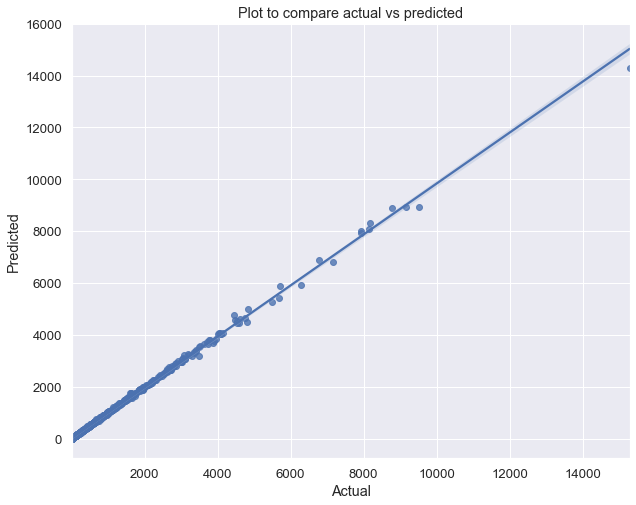

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=et_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Using XGBoost

In [30]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [31]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:1181.39246
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:863.08588
[2]	validation_0-rmse:644.57874
[3]	validation_0-rmse:485.60269
[4]	validation_0-rmse:373.12955
[5]	validation_0-rmse:288.04297
[6]	validation_0-rmse:231.50661
[7]	validation_0-rmse:186.68718
[8]	validation_0-rmse:154.55756
[9]	validation_0-rmse:131.36688
[10]	validation_0-rmse:113.58038
[11]	validation_0-rmse:100.07642
[12]	validation_0-rmse:90.48927
[13]	validation_0-rmse:83.20284
[14]	validation_0-rmse:77.30017
[15]	validation_0-rmse:72.70174
[16]	validation_0-rmse:69.10767
[17]	validation_0-rmse:66.90966
[18]	validation_0-rmse:65.34459
[19]	validation_0-rmse:64.24992
[20]	validation_0-rmse:62.72107
[21]	validation_0-rmse:61.60207
[22]	validation_0-rmse:60.84928
[23]	validation_0-rmse:60.12308
[24]	validation_0-rmse:59.51631
[25]	validation_0-rmse:59.01441
[26]	validation_0-rmse:58.92400
[27]	validation_0-rmse:58.79658
[28]	validation_0-rmse:58.64072
[29]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [32]:
xgb_pred = xgbmodel.predict(X_test_scaled)

In [33]:
xgb_pred[:10]

array([  27.299465,  238.74037 ,   16.09712 ,  105.65489 ,  384.64874 ,
        365.38757 ,  224.14505 , 1420.7906  ,  481.03943 ,  765.69037 ],
      dtype=float32)

### Model Evaluation

In [34]:
mse = mean_squared_error(y_test,xgb_pred)
mse

3148.879749555135

In [35]:
rmse = np.sqrt(mse)
rmse

56.11487992997165

In [36]:
r2score = r2_score(y_test,xgb_pred)
r2score

0.9983629111213329

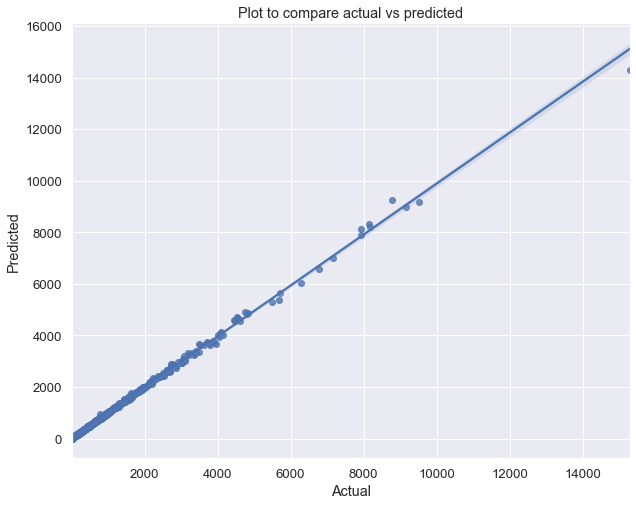

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=xgb_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [38]:
X.columns

Index(['DaySum', 'QuantitySum', 'TotalPriceSum', 'CustomerCount', 'DayAvg', 'MonthAvg', 'QuantityAvg'], dtype='object')

In [39]:
xgbmodel.get_booster().feature_names = ['DaySum', 'QuantitySum', 'TotalPriceSum', 'CustomerCount', 'DayAvg', 'MonthAvg', 'QuantityAvg']

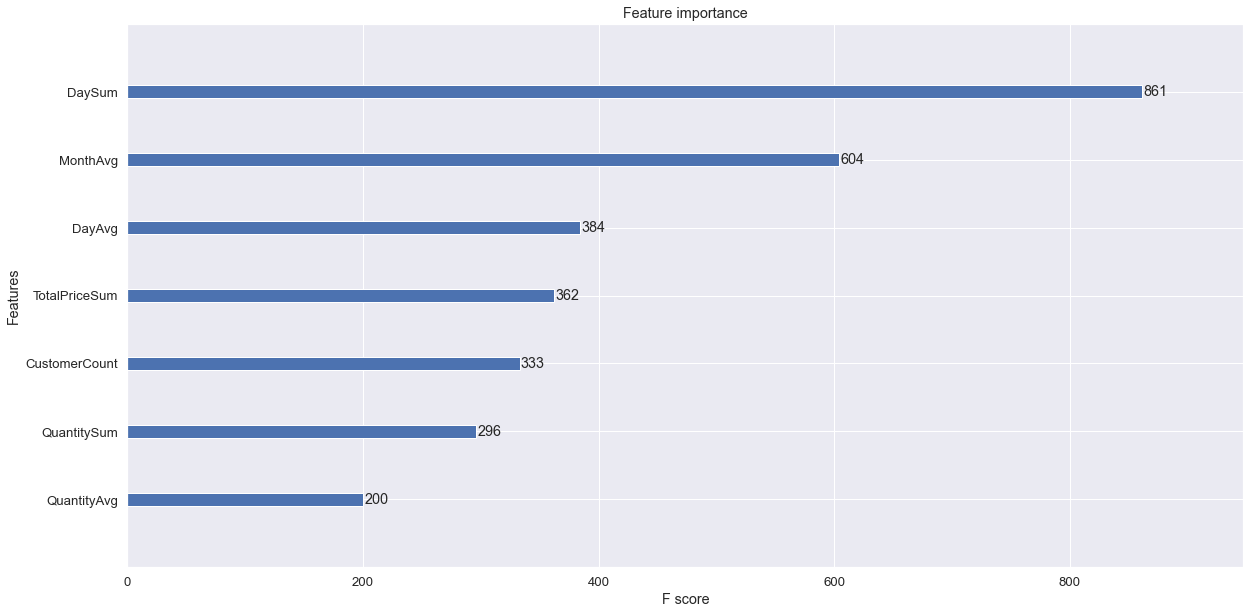

In [40]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

### Cross-Validation

In [41]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


In [42]:
cv.mean()

0.9977069585289394

### Model Tuning

### Using RandomSearchCV

In [43]:
model = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [44]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.05),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [45]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 15, 
                           n_jobs=-1, scoring='r2')

In [46]:
randm.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                        'gamma': array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48]),
                         

In [47]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=34, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.2, learning_rate=0.300000012, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
randm.best_score_

0.9964929755309481

In [49]:
randm.best_params_

{'subsample': 0.6,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 4,
 'learning rate': 0.2,
 'gamma': 34,
 'colsample_bytree': 0.7}

### Articulate your findings in a summary report

XGB Boost Regressor has slightly better than Extra Tree Regressor. We chose the simple model for the deployment